In [2]:
# Imports
import numpy as np
import time
from tsp_utils import read_tsp_file

# Optional plotting (comment out if running headless)
import matplotlib.pyplot as plt

In [3]:
def get_distance_matrix(coordinates):
    num_cities = len(coordinates)
    distance_matrix = np.zeros((num_cities, num_cities))
    for i in range(num_cities):
        for j in range(num_cities):
            distance_matrix[i][j] = np.linalg.norm(coordinates[i] - coordinates[j])
    return distance_matrix

In [4]:
def calculate_total_distance(route, distance_matrix):
    total_distance = 0
    for i in range(len(route) - 1):
        total_distance += distance_matrix[route[i], route[i + 1]]
    total_distance += distance_matrix[route[-1], route[0]]
    return total_distance

def get_neighbor(route):
    a, b = np.random.randint(0, len(route), size=2)
    if a > b:
        a, b = b, a
    new_route = route.copy()
    new_route[a:b+1] = new_route[a:b+1][::-1]
    return new_route

In [5]:
# Genetic algorithm helper functions (copied/adapted from the course notebook)
def initialize_population(pop_size, num_cities):
    return np.array([np.random.permutation(num_cities) for _ in range(pop_size)])

def evaluate_fitness(population, distance_matrix):
    pop_size = population.shape[0]
    total_distances = np.zeros(pop_size)
    for i in range(pop_size):
        route = population[i]
        total_distance = calculate_total_distance(route, distance_matrix)
        total_distances[i] = total_distance
    # Avoid division by zero
    fitness = 1 / (total_distances + 1e-12)
    return fitness, total_distances

def tournament_selection(population, fitness, tournament_size):
    pop_size = population.shape[0]
    selected_indices = []
    for _ in range(pop_size):
        participants = np.random.choice(pop_size, tournament_size, replace=False)
        best = participants[np.argmax(fitness[participants])]
        selected_indices.append(best)
    return population[selected_indices]

def roulette_selection(population, fitness):
    total_fitness = np.sum(fitness)
    probabilities = fitness / total_fitness
    pop_size = population.shape[0]
    selected_indices = np.random.choice(pop_size, size=pop_size, p=probabilities)
    return population[selected_indices]

def crossover_operator(parent1, parent2):
    num_genes = len(parent1)
    a, b = np.random.randint(0, num_genes, size=2)
    if a > b:
        a, b = b, a
    child = -np.ones(num_genes, dtype=int)
    child[a:b+1] = parent1[a:b+1]
    current_pos = (b + 1) % num_genes
    for gene in parent2:
        if gene not in child:
            child[current_pos] = gene
            current_pos = (current_pos + 1) % num_genes
    return child

def crossover(parents, crossover_rate):
    num_parents, num_genes = parents.shape
    np.random.shuffle(parents)
    offspring = []
    for i in range(0, num_parents, 2):
        parent1 = parents[i]
        parent2 = parents[i + 1 if i + 1 < num_parents else 0]
        if np.random.rand() < crossover_rate:
            child1 = crossover_operator(parent1, parent2)
            child2 = crossover_operator(parent2, parent1)
        else:
            child1 = parent1.copy()
            child2 = parent2.copy()
        offspring.append(child1)
        offspring.append(child2)
    return np.array(offspring)

def mutation(offspring, mutation_rate):
    num_offspring, num_genes = offspring.shape
    for i in range(num_offspring):
        if np.random.rand() < mutation_rate:
            a, b = np.random.randint(0, num_genes, size=2)
            offspring[i, a], offspring[i, b] = offspring[i, b], offspring[i, a]
    return offspring

def elitism(population, fitness, elite_size):
    elite_indices = np.argsort(fitness)[-elite_size:]
    return population[elite_indices]

In [6]:
def genetic_algorithm(distance_matrix, pop_size=100, num_generations=200, crossover_rate=0.8,
                      mutation_rate=0.05, elite_percent=0.02, selection_type='tournament', tournament_size=3):
    num_cities = distance_matrix.shape[0]
    elite_size = max(1, int(pop_size * elite_percent))
    population = initialize_population(pop_size, num_cities)
    average_distance_history = []
    best_distance_history = []
    for generation in range(num_generations):
        fitness, total_distances = evaluate_fitness(population, distance_matrix)
        average_distance = np.mean(total_distances)
        best_distance = np.min(total_distances)
        average_distance_history.append(average_distance)
        best_distance_history.append(best_distance)
        elites = elitism(population, fitness, elite_size)
        if selection_type == 'tournament':
            parents = tournament_selection(population, fitness, tournament_size)
        elif selection_type == 'roulette':
            parents = roulette_selection(population, fitness)
        else:
            raise ValueError("Type de sélection invalide")
        offspring = crossover(parents, crossover_rate)
        offspring = mutation(offspring, mutation_rate)
        population = np.vstack((elites, offspring))
        if population.shape[0] > pop_size:
            population = population[:pop_size]
        elif population.shape[0] < pop_size:
            num_new_individuals = pop_size - population.shape[0]
            new_individuals = initialize_population(num_new_individuals, num_cities)
            population = np.vstack((population, new_individuals))
    fitness, total_distances = evaluate_fitness(population, distance_matrix)
    best_index = np.argmax(fitness)
    best_solution = population[best_index]
    best_distance = total_distances[best_index]
    return best_solution, best_distance, average_distance_history, best_distance_history

def genetic_algorithm_do_n(distance_matrix, pop_size=100, num_generations=200, crossover_rate=0.8,
                           mutation_rate=0.05, elite_percent=0.02, selection_type='tournament',
                           tournament_size=3, repeats=20):
    start_time = time.time()
    results = [
        genetic_algorithm(distance_matrix, pop_size, num_generations, crossover_rate,
                          mutation_rate, elite_percent, selection_type, tournament_size)
        for _ in range(repeats)
    ]
    best_solution, distance, averages, bests = min(results, key=lambda x: x[1])
    end_time = time.time()
    elapsed_time = round(end_time - start_time, 3)
    return best_solution, distance, averages, bests, elapsed_time

def plot_fitness_over_generations(avg_distances, best_distances):
    generations = range(1, len(avg_distances) + 1)
    plt.figure(figsize=(6, 6))
    plt.plot(generations, avg_distances, label='Distance Moyenne')
    plt.plot(generations, best_distances, label='Meilleure Distance')
    plt.xlabel('Génération')
    plt.ylabel('Distance')
    plt.title('Distance au fil des générations')
    plt.legend()
    plt.show()

Loaded 150 cities
Best distance: 15899.073433764754
Elapsed (all repeats): 48.463 s
Best distance: 15899.073433764754
Elapsed (all repeats): 48.463 s


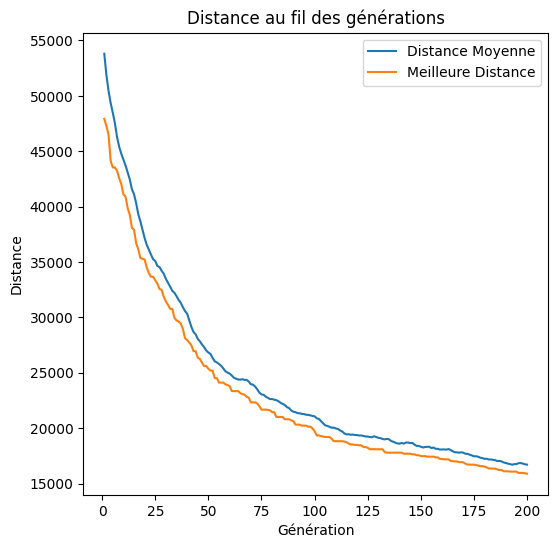

In [ ]:
# Read the local TSP file and run the GA
coords = read_tsp_file('ch150.tsp')
if coords is None:
    raise FileNotFoundError('Could not read ch150.tsp with read_tsp_file')

M = get_distance_matrix(coords)
print('Loaded', coords.shape[0], 'cities')

# We'll use a small helper that mirrors the notebook's genetic_algorithm_results to record and plot the best run
ga_results_list = []

def genetic_algorithm_results(distance_matrix, t_list, pop_size=200, num_generations=200, crossover_rate=0.9, mutation_rate=0.02, elite_percent=0.02, selection_type='tournament', tournament_size=5, repeats=5):
    # Run the repeated GA and return best solution and distance (also append to t_list)
    best_solution, best_distance, avg_history, best_history, elapsed_time = genetic_algorithm_do_n(distance_matrix, pop_size=pop_size, num_generations=num_generations, crossover_rate=crossover_rate, mutation_rate=mutation_rate, elite_percent=elite_percent, selection_type=selection_type, tournament_size=tournament_size, repeats=repeats)
    t_list.append((best_solution, best_distance, elapsed_time))
    try:
        plot_fitness_over_generations(avg_history, best_history)
    except Exception:
        pass
    return best_solution, best_distance, elapsed_time

# Run the GA using the helper so the best path is captured in ga_results_list
best_solution, best_distance, elapsed = genetic_algorithm_results(M, ga_results_list, pop_size=200, num_generations=200, crossover_rate=0.9, mutation_rate=0.02, elite_percent=0.02, selection_type='tournament', tournament_size=5, repeats=5)
print('Best distance:', best_distance)
print('Elapsed (all repeats):', elapsed, 's')
# Show the path as 0-based indices and as 1-based (city labels) to be friendly
print('Best path (0-based indices):', best_solution)
print('Best path (1-based indices):', (best_solution + 1).tolist())